### Importing the pretrained NLP model

In this notebook we will first apply a pre trained model to process the titles from Reddit, and then we perform a simple LinearRegression. The results are not satisfying.

Importing the pre trained NLP model:

In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <B3E58761-2785-34C6-A89B-F37110C88A05> /opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <3BD7C270-CE25-3DCF-A6C8-B9D7148F8ADE> /opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


Importing the dataset from the .zip file:

In [104]:
from data_preparation_utilities import read_csv_from_zip
Combined_News_DJIA, DJIA_table, RedditNews, Test_dates = read_csv_from_zip()
DJIA_table = DJIA_table.iloc[::-1].reset_index(drop=True)

In [106]:
DJIA_table['Close']

0       11734.32031
1       11782.34961
2       11642.46973
3       11532.95996
4       11615.92969
           ...     
1858    17552.16992
1859    17528.26953
1860    17720.98047
1861    17603.86914
1862    17425.02930
Name: Close, Length: 1863, dtype: float64

In [36]:
Combined_News_DJIA = Combined_News_DJIA.drop(columns=['Date', 'Label'], axis=1)
nan_count_per_column = Combined_News_DJIA.isna().sum()
nan_positions = Combined_News_DJIA.isna().stack()
nan_positions = nan_positions[nan_positions]

print(nan_positions)


277  Top23    True
     Top24    True
     Top25    True
348  Top24    True
     Top25    True
681  Top24    True
     Top25    True
dtype: bool


### Removing the NAN entries in the dataset

In [48]:
Combined_News_DJIA.iloc[277, -3:] = Combined_News_DJIA.iloc[277, -6:-3]

Combined_News_DJIA.iloc[348, -2:] = Combined_News_DJIA.iloc[277, -4:-2]

Combined_News_DJIA.iloc[681, -2:] = Combined_News_DJIA.iloc[681, -4:-2]

In [49]:
import scipy
import torch.nn.functional as F
import torch
import pandas as pd
import numpy as np
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
Combined_News_DJIA_np = Combined_News_DJIA.to_numpy()
n = Combined_News_DJIA_np.shape[0]
final = np.zeros((1, 75))
for i in range(n):
    print(i)
    x = [char for char in Combined_News_DJIA_np[i].tolist()]
    input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
    logits = model_finbert(**input_sequence).logits
    probabilities = F.softmax(logits, dim=-1).view(1, 75)
    probabilities_np = probabilities.detach().numpy()
    final = np.concatenate((final, probabilities_np), axis=0)

df = pd.DataFrame(final)

# Save the DataFrame as a CSV file
df.to_csv('tensor_data.csv', index=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [70]:
df = pd.read_csv('titles_after_NLP.csv')
df = df.drop(index=0)
df = df.reset_index(drop=True)

In [71]:
df.shape

(1989, 75)

### Prepared the input

In [83]:
adj_close = Combined_News_DJIA['Label']
merged_df = pd.concat([df, adj_close], axis=1)
print(merged_df.shape)
input = merged_df.iloc[:1863, :]
input.shape


(1989, 76)


(1863, 76)

### Prepared the output

In [108]:
output = DJIA_table['Close']
output.shape

(1863,)

### Now we start to train the model

In [110]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [124]:
# Split the data into training and testing sets
x = input  # Independent variable
y = output     # Dependent variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [125]:
x.shape

(1863, 76)

In [126]:
y.shape

(1863,)

In [127]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

In [128]:

# Make predictions on the test set
y_pred = model.predict(x_test)

In [129]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 6587046.302039085
R^2 Score: 0.308084146089734


(373,)


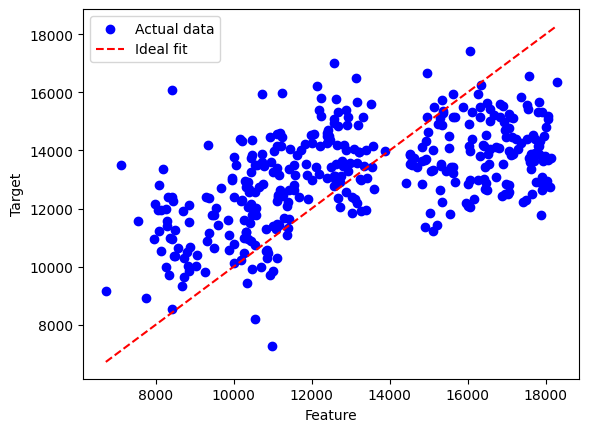

In [150]:
# Plot the results

domain = np.arange(1, len(y_test) + 1)
print(domain.shape)


plt.scatter(y_test, y_pred, color='blue', label='Actual data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()